In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.stats.diagnostic as diag
from sklearn.naive_bayes import GaussianNB
#Metrics
from sklearn.metrics import make_scorer, accuracy_score,precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score

In [9]:
data = pd.read_csv('train.csv').drop(['Id'], axis = 1)
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [11]:
predictors_1 = ['GrLivArea', 'GarageCars', 'TotalBsmtSF', 'OverallQual']
data[predictors_1]

,GrLivArea,GarageCars,TotalBsmtSF,OverallQual
0,1710,2,856,7
1,1262,2,1262,6
2,1786,2,920,7
3,1717,3,756,7
4,2198,3,1145,8
...,...,...,...,...
1455,1647,2,953,6
1456,2073,2,1542,6
1457,2340,1,1152,7
1458,1078,1,1078,5


<AxesSubplot:>

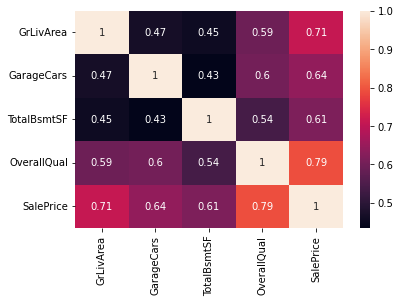

In [14]:

sns.heatmap(data[predictors_1 + ['SalePrice']].corr(), xticklabels=data[predictors_1 + ['SalePrice']].corr().columns, yticklabels=data[predictors_1 + ['SalePrice']].corr().columns, annot=True)


#### Como primer modelo para redes bayesianas se escogieron variables con una alta correlación con SalePrice, que no tuvieran una correlación entre sí para asegurar independencia y que fueran datos significativos para decidir sobre el precio de una casa. Se basa en SalePrice ya que esta es la variable que al final termina determinando la categoría de cada una de las casas

### Variable categorica de precio

In [15]:
low_price_limit = data.SalePrice.quantile(0.33)
mid_price_limit = data.SalePrice.quantile(0.67)

(low_price_limit, mid_price_limit)

(139000.0, 191000.0)

In [16]:
data['PriceRange'] = 'Intermedio'
data['PriceRange'][data['SalePrice'] < low_price_limit] = 'Bajo'
data['PriceRange'][data['SalePrice'] > mid_price_limit] = 'Alto'
data['PriceRange']

C:\Users\josej\AppData\Local\Temp\ipykernel_4700\406839980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PriceRange'][data['SalePrice'] < low_price_limit] = 'Bajo'
C:\Users\josej\AppData\Local\Temp\ipykernel_4700\406839980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PriceRange'][data['SalePrice'] > mid_price_limit] = 'Alto'


0             Alto
1       Intermedio
2             Alto
3       Intermedio
4             Alto
           ...    
1455    Intermedio
1456          Alto
1457          Alto
1458    Intermedio
1459    Intermedio
Name: PriceRange, Length: 1460, dtype: object

### Establecimiento del conjunto de prueba y entrenamiento

In [17]:
y = data['PriceRange'] #La variable respuesta
X = data[predictors_1] #El resto de los datos
random.seed(123)

X_train, X_test,y_train, y_test = train_test_split(X, y,test_size=0.3,train_size=0.7)

### Creación del modelo

In [18]:
gaussian = GaussianNB()
gaussian.fit(X_train,y_train)
y_pred = gaussian.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
cm

array([[105,   0,  42],
       [  2, 117,  22],
       [ 10,  37, 103]], dtype=int64)

In [19]:
accuracy=accuracy_score(y_test,y_pred)
precision =precision_score(y_test, y_pred,average='micro')
recall =  recall_score(y_test, y_pred,average='micro')
f1 = f1_score(y_test,y_pred,average='micro')
print('Accuracy: ',accuracy)

Accuracy:  0.7420091324200914
